# DengAI Analysis Part 7b - Time Series Analysis (Continued)

By: Chengyi (Jeff) Chen, under guidance of CSCI499: AI for Social Good Teaching Assistant - Aaron Ferber

---
## Content

Continuing from our previous work in SARIMAX, let's try to just make a SARIMA model instead, excluding the exogenous features that seem to create more noise than necessary for our prediction.

<a id="imports"></a>

---
## Library Imports

In [1]:
# Library Imports
import sys
import pandas as pd
import numpy as np
import subprocess
import statsmodels.api as sm
from scipy import stats
import os
from collections import Counter
from sklearn import model_selection, kernel_ridge, linear_model, metrics, feature_selection, preprocessing
from os import listdir
from os.path import isfile, join, isdir
from  tqdm import  tqdm
import warnings
warnings.filterwarnings('ignore')

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
sns.set(style="ticks")
from pylab import rcParams
%matplotlib inline

In [2]:
# DengAI dataset URLs
dengai_features_url = 'https://www.dropbox.com/s/1kuf94b4mk6axyy/dengue_features_train.csv'
dengai_labels_url = 'https://www.dropbox.com/s/626ak8397abonv4/dengue_labels_train.csv'
dengai_test_features_url = 'https://s3.amazonaws.com:443/drivendata/data/44/public/dengue_features_test.csv'

In [3]:
# Helper function to create a new folder
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print("(%s) already exists" % (path))

<a id="clean_feats"></a>

---
## Cleaned Features

In [4]:
sj_X = pd.read_csv('./data/dengai/cleaned/sj_X.csv', index_col='week_start_date')
sj_y = pd.read_csv('./data/dengai/cleaned/sj_y.csv', header=None, names=['week_start_date', 'num_cases'], index_col='week_start_date')
iq_X = pd.read_csv('./data/dengai/cleaned/iq_X.csv', index_col='week_start_date')
iq_y = pd.read_csv('./data/dengai/cleaned/iq_y.csv', header=None, names=['week_start_date', 'num_cases'], index_col='week_start_date')

---
## Seasonal AutoRegressive Integrated Moving Average (SARIMA)

In [5]:
test_dates = pd.read_csv('./data/dengai/test_features/dengue_features_test.csv', index_col='week_start_date')['city']
sj_y = pd.concat([sj_y, pd.DataFrame(index=test_dates[test_dates == 'sj'].index, columns=['num_cases'])], axis=0)
iq_y = pd.concat([iq_y, pd.DataFrame(index=test_dates[test_dates == 'iq'].index, columns=['num_cases'])], axis=0)

In [6]:
sj_X_train = pd.read_csv('./data/dengai/cleaned/sj_X.csv', index_col=[0])
iq_X_train = pd.read_csv('./data/dengai/cleaned/iq_X.csv', index_col=[0])

# Clean Test Features
test_feats_df = pd.read_csv('./data/dengai/test_features/dengue_features_test.csv', index_col='week_start_date')

# Taking care of missing data
test_feats_df.fillna(test_feats_df.mode().iloc[0], inplace=True)

# Drop unecessary feature columns
test_feats_df = test_feats_df.drop(['year', 'weekofyear'], axis=1)

# Split dataset to City sj and City iq
sj_X_test = test_feats_df[test_feats_df['city'] == 'sj'].drop(['city'], axis=1)
iq_X_test = test_feats_df[test_feats_df['city'] == 'iq'].drop(['city'], axis=1)

In [7]:
def get_best_sarimax_start(results, y, X=None, min_samples=50, max_samples=None):
    """
    ============
    = FUNCTION =
    ============
    Function to find the best number of samples to 
    use SARIMAX to predict on to get lowest MAE
    
    ==============
    = PARAMETERS =
    ==============
    results: MLE Estimate of SARIMAX
    y: DataFrame of the total dengue cases
    X: DataFrame with exogenous features required for our SARIMAX
    min_samples: The minimum number of samples used to make a prediction on
    max_samples: The maximum number of samples used to make a prediction on
    
    ===========
    = RETURNS =
    ===========
    predictions: The dictionary of DataFrames containing the predictions of total number of dengue cases
    residuals: The dicitionary of Series containing the residuals between predictions and ground truth values of total dengue cases
    best_start: The most optimal location to start the prediction in order to eliminate seasonality and get lowest MAE
    maes: The dictionary of mae scores for each starting point
    
    """
    # Parameters we tuned to get the best model for City predictions
    best_start = 0
    best_mae = sys.maxsize
    predictions = {start: None for start in range(min_samples, max_samples)}
    residuals = {start: None for start in range(min_samples, max_samples)}
    maes = {start: None for start in range(min_samples, max_samples)}

    # Loop through all the possible training samples we can train on
    for start in tqdm(range(min_samples, max_samples)):
        
        # Predict for City 
        if X:
            predictions[start] = pd.DataFrame(
                [np.nan for i in range(start)] +
                list(map(int, results.predict(
                    start=start,
                    end=len(y['num_cases']) - 1,
                    exog=X.loc[y['num_cases'].last_valid_index():].iloc[1:], # Exogenous Features from Out of Sample forecast onwards
                    dynamic=True))), 
                index=y['num_cases'].index,
                columns=['num_cases'])
        else:
            predictions[start] = pd.DataFrame(
                [np.nan for i in range(start)] +
                list(map(int, results.predict(
                    start=start,
                    end=len(y['num_cases']) - 1,
                    dynamic=True))), 
                index=y['num_cases'].index,
                columns=['num_cases'])
        
        # Get Training Data Residuals
        residuals[start] = y['num_cases'].loc[y.iloc[start].name:y['num_cases'].last_valid_index()] - predictions[start]['num_cases'].loc[y.iloc[start].name:y['num_cases'].last_valid_index()]
        mae = np.sum(np.abs(residuals[start])) / len(residuals[start])
        maes[start] = mae
        
        if mae < best_mae:
            best_start = start
            best_mae = mae
    
    print('Best Number of Training Samples: {}'.format(best_start))
    print('Best MAE on Training Data: {}'.format(best_mae))
    
    return predictions, residuals, maes, best_start

In [8]:
sj_mod = sm.tsa.statespace.SARIMAX(endog=np.asarray(sj_y['num_cases'][:sj_y['num_cases'].last_valid_index()].astype(int)),
                                   trend='n', 
                                   order=(0,0,0), 
                                   seasonal_order=(1,1,1,52))
sj_results = sj_mod.fit()
print(sj_results.summary())

                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                  936
Model:             SARIMAX(1, 1, 1, 52)   Log Likelihood               -4748.939
Date:                  Fri, 19 Apr 2019   AIC                           9503.877
Time:                          11:00:15   BIC                           9518.230
Sample:                               0   HQIC                          9509.365
                                  - 936                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52      -0.1668      0.031     -5.297      0.000      -0.229      -0.105
ma.S.L52      -0.8254      0.036    -23.096      0.000      -0.895      -0.755
sigma2      2496.1366     72.902    

100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


Best Number of Training Samples: 65
Best MAE on Training Data: 24.303099885189436


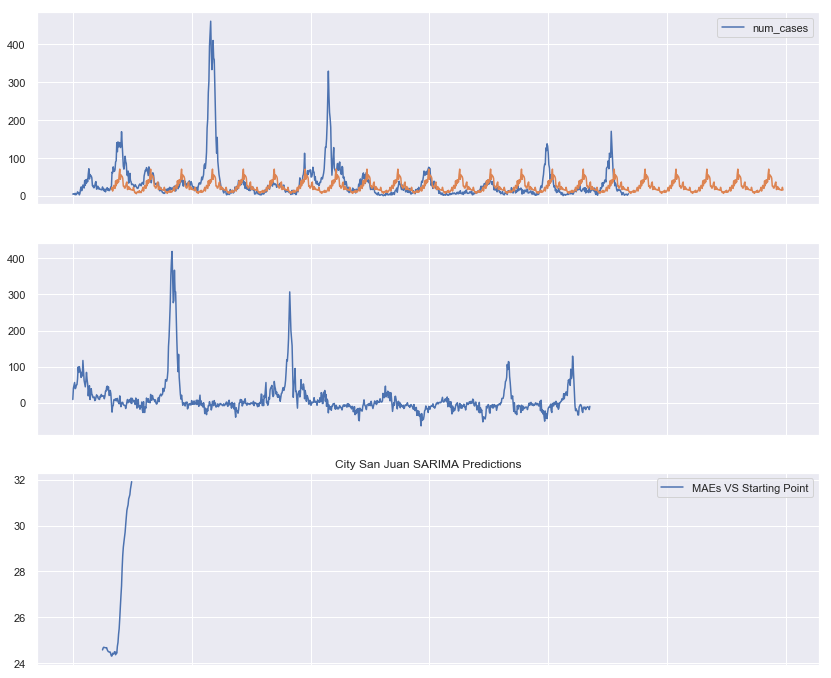

In [9]:
# Get Best Model
sj_pred, sj_resid, sj_maes, sj_best_start = get_best_sarimax_start(sj_results, sj_y, min_samples=50, max_samples=100)

# Plot the Predictions against Original
sns.set()
fig, ax = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
sj_y[['num_cases']].plot(ax=ax[0])
sj_pred[sj_best_start]['num_cases'].plot(ax=ax[0], label="Total Predicted Number of Dengue Cases")
sj_resid[sj_best_start].plot(ax=ax[1])
ax[2].plot(sj_maes.keys(), sj_maes.values(), label="MAEs VS Starting Point")

plt.title('City San Juan SARIMA Predictions')
plt.legend()
plt.show();

In [10]:
iq_mod = sm.tsa.statespace.SARIMAX(endog=np.asarray(iq_y['num_cases'][:iq_y['num_cases'].last_valid_index()].astype(int)),
                                   trend='n',
                                   order=(0,0,0),
                                   seasonal_order=(1,1,1,52))
iq_results = iq_mod.fit()
print(iq_results.summary())

                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                  520
Model:             SARIMAX(1, 1, 1, 52)   Log Likelihood               -1813.478
Date:                  Fri, 19 Apr 2019   AIC                           3632.956
Time:                          11:00:41   BIC                           3645.401
Sample:                               0   HQIC                          3637.853
                                  - 520                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52      -0.2040      0.048     -4.278      0.000      -0.297      -0.111
ma.S.L52      -0.7511      0.043    -17.460      0.000      -0.835      -0.667
sigma2       119.5585      2.907    

100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Best Number of Training Samples: 131
Best MAE on Training Data: 6.015424164524422


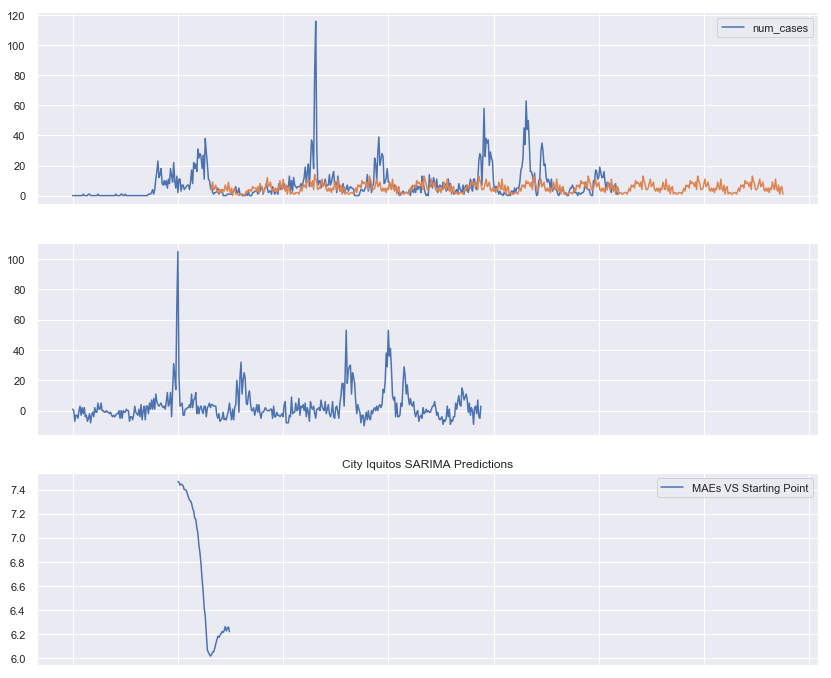

In [11]:
# Get Best Model
iq_pred, iq_resid, iq_maes, iq_best_start = get_best_sarimax_start(iq_results, iq_y, min_samples=100, max_samples=150)

# Plot the Predictions against Original
sns.set()
fig, ax = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
iq_y[['num_cases']].plot(ax=ax[0])
iq_pred[iq_best_start]['num_cases'].plot(ax=ax[0], label="Total Predicted Number of Dengue Cases")
iq_resid[iq_best_start].plot(ax=ax[1])
ax[2].plot(iq_maes.keys(), iq_maes.values(), label="MAEs VS Starting Point")

plt.title('City Iquitos SARIMA Predictions')
plt.legend()
plt.show();

In [12]:
# Save the results to csv and upload to competition
submission_df = pd.read_csv('./data/dengai/submission_format.csv')

# City SJ
sj_submission_df = submission_df[submission_df['city'] == 'sj'].drop(['total_cases'], axis=1)
sj_submission_df.reset_index(inplace=True)
sj_submission_df = pd.concat([sj_submission_df, 
                              pd.DataFrame(sj_pred[sj_best_start].loc[test_dates[test_dates == 'sj'].index]['num_cases'].values.flatten().astype(int),
                                           columns=['total_cases'])], 
                             axis=1)
sj_submission_df.index = sj_submission_df['index']
sj_submission_df.drop(['index'], axis=1, inplace=True)

# City IQ
iq_submission_df = submission_df[submission_df['city'] == 'iq'].drop(['total_cases'], axis=1)
iq_submission_df.reset_index(inplace=True)
iq_submission_df = pd.concat([iq_submission_df, 
                              pd.DataFrame(iq_pred[iq_best_start].loc[test_dates[test_dates == 'iq'].index]['num_cases'].values.flatten().astype(int), 
                                           columns=['total_cases'])], 
                             axis=1)
iq_submission_df.index = iq_submission_df['index']
iq_submission_df.drop(['index'], axis=1, inplace=True)

submission_df = pd.concat([sj_submission_df, iq_submission_df], axis=0).reset_index().drop(['index'], axis=1)
submission_df.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,10
1,sj,2008,19,8
2,sj,2008,20,10
3,sj,2008,21,6
4,sj,2008,22,10


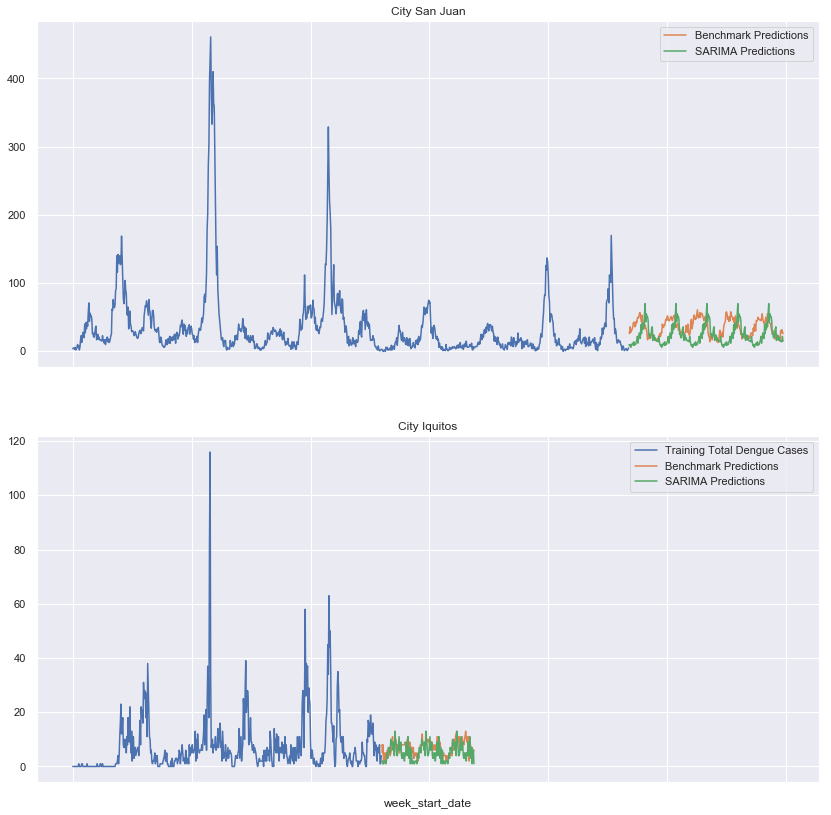

In [13]:
# Benchmark Predictions
benchmark = pd.read_csv('./data/dengai/benchmark.csv')

sj_bench = benchmark[benchmark['city'] == 'sj']['total_cases']
sj_bench = pd.DataFrame([np.nan for i in range(len(sj_y.loc[:sj_y.last_valid_index()]))] + list(sj_bench.values),
                         index=sj_y.index,
                         columns=['Benchmark Predictions'])

iq_bench = benchmark[benchmark['city'] == 'iq']['total_cases']
iq_bench = pd.DataFrame([np.nan for i in range(len(iq_y.loc[:iq_y.last_valid_index()]))] + list(iq_bench.values),
                         index=iq_y.index,
                         columns=['Benchmark Predictions'])

# SARIMA Predictions
sj_sarima = sj_pred[sj_best_start].loc[test_dates[test_dates == 'sj'].index]['num_cases']
sj_sarima = pd.DataFrame([np.nan for i in range(len(sj_y.loc[:sj_y.last_valid_index()]))] + list(sj_sarima.values),
                         index=sj_y.index,
                         columns=['SARIMA Predictions'])

iq_sarima = iq_pred[iq_best_start].loc[test_dates[test_dates == 'iq'].index]['num_cases']
iq_sarima = pd.DataFrame([np.nan for i in range(len(iq_y.loc[:iq_y.last_valid_index()]))] + list(iq_sarima.values),
                         index=iq_y.index,
                         columns=['SARIMA Predictions'])

# Plot 
sns.set()
fig, ax = plt.subplots(2, 1, figsize=(14, 14), sharex=True)

ax[0].set_title("City San Juan")
ax[0].plot(sj_y[['num_cases']].values, label="Training Total Dengue Cases")
sj_bench.plot(ax=ax[0])
sj_sarima.plot(ax=ax[0])

ax[1].set_title("City Iquitos")
ax[1].plot(iq_y[['num_cases']].values, label="Training Total Dengue Cases")
iq_bench.plot(ax=ax[1])
iq_sarima.plot(ax=ax[1])

plt.legend()
plt.show();

In [14]:
# Save to csv
submission_df.to_csv('./data/dengai/sarima_submission.csv', index=False)

__This seemed to have identified and was able to eliminate most of the seasonality in our dataset. Instead of purely submitting this, let's use these seasonality trends as a new feature in our sklearn ML models in the next part.__

In [15]:
sj_pred[sj_best_start].to_csv('./data/dengai/cleaned/sj_seasonality.csv')
iq_pred[iq_best_start].to_csv('./data/dengai/cleaned/iq_seasonality.csv')